# 6.6 Sourcing & Analyzing Time Series Data

In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [6]:
# Configure API key 

quandl.ApiConfig.api_key = 'jRFs181NPWBiK8eJCsBm'

In [30]:
# Importing the Zillow Real Estate Data. There wasn't anything close to Airbnb or Argentina so I went for real state and I will focus on California as some day I would love to live there 
data = quandl.get_table('ZILLOW/DATA')
regions = quandl.get_table('ZILLOW/REGIONS')
indicators = quandl.get_table('ZILLOW/INDICATORS')

In [24]:
data.head()


,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2025-01-31,457847.242831
1,ZSFH,99999,2024-12-31,457250.597887
2,ZSFH,99999,2024-11-30,456891.816779
3,ZSFH,99999,2024-10-31,456998.542716
4,ZSFH,99999,2024-09-30,456517.913569


In [34]:
data.shape

(10000, 4)

In [26]:
regions.head()

,region_id,region_type,region
None,,,
0,99999,zip,"98847;WA;Wenatchee, WA;Leavenworth;Chelan County"
1,99998,zip,98846;WA;nan;Pateros;Okanogan County
2,99997,zip,98845; WA; Wenatchee; Douglas County; Palisades
3,99996,zip,98844;WA;nan;Oroville;Okanogan County
4,99995,zip,"98843;WA;Wenatchee, WA;Orondo;Douglas County"


In [36]:
regions.shape

(10000, 3)

In [32]:
indicators.head()

,indicator_id,indicator,category
None,,,
0,ZSFH,ZHVI Single-Family Homes Time Series ($),Home values
1,ZCON,ZHVI Condo/Co-op Time Series ($),Home values
2,ZATT,ZHVI All Homes- Top Tier Time Series ($),Home values
3,ZALL,"ZHVI All Homes (SFR, Condo/Co-op) Time Series ($)",Home values
4,ZABT,ZHVI All Homes- Bottom Tier Time Series ($),Home values


In [38]:
indicators.shape

(56, 3)

### 2. Subsetting, wrangling, and cleaning time-series data

In [107]:
# I am interested in creating a time series for the whole country, so I will be using only the data df and I will not subset

In [99]:
data.dtypes

indicator_id            object
region_id               object
date            datetime64[ns]
value                  float64
dtype: object

##### Looks correct

In [102]:
# Check for duplicates
dups = data[data.duplicated()]

print(dups)

Empty DataFrame
Columns: [indicator_id, region_id, date, value]
Index: []


##### No duplicates

In [105]:
# Check for missing values
data.isnull().sum()

indicator_id    0
region_id       0
date            0
value           0
dtype: int64

#### there are no missing values 

In [112]:
# Check each column in df for mixed data types
for col in data.columns:
    # Get the unique types found in the column
    unique_types = data[col].apply(lambda x: type(x)).unique()
    # If more than one unique type is found, print the column name and its types
    if len(unique_types) > 1:
        print(f"Column '{col}' has mixed types: {unique_types}")


#### no mixed data types 

In [115]:
# Group by 'date' and calculate the mean value for each date
us_prices = data.groupby('date')['value'].mean().reset_index()

In [117]:
us_prices.head()

,date,value
0,1996-01-31,142168.833333
1,1996-02-29,142608.500000
2,1996-03-31,142872.333333
3,1996-04-30,143335.333333
4,1996-05-31,144060.500000


In [119]:
us_prices.describe()

,date,value
count,349,349.000000
mean,2010-07-31 06:07:13.237822464,222724.516821
min,1996-01-31 00:00:00,137265.909091
25%,2003-04-30 00:00:00,159469.062253
50%,2010-07-31 00:00:00,186554.556195
75%,2017-10-31 00:00:00,246558.816514
max,2025-01-31 00:00:00,447203.753165
std,NaN,89673.040336


In [123]:
# Convert the data column in to the index 
from datetime import datetime

# Convert the 'date' column to datetime and create a new 'datetime' column
us_prices['datetime'] = pd.to_datetime(us_prices['date'])

# Set the 'datetime' column as the index of the DataFrame
us_prices = us_prices.set_index('datetime')

# Drop the original 'date' column
us_prices.drop(['date'], axis=1, inplace=True)

# Display the first few rows of the updated DataFrame
us_prices.head()

,value
datetime,
1996-01-31,142168.833333
1996-02-29,142608.500000
1996-03-31,142872.333333
1996-04-30,143335.333333
1996-05-31,144060.500000


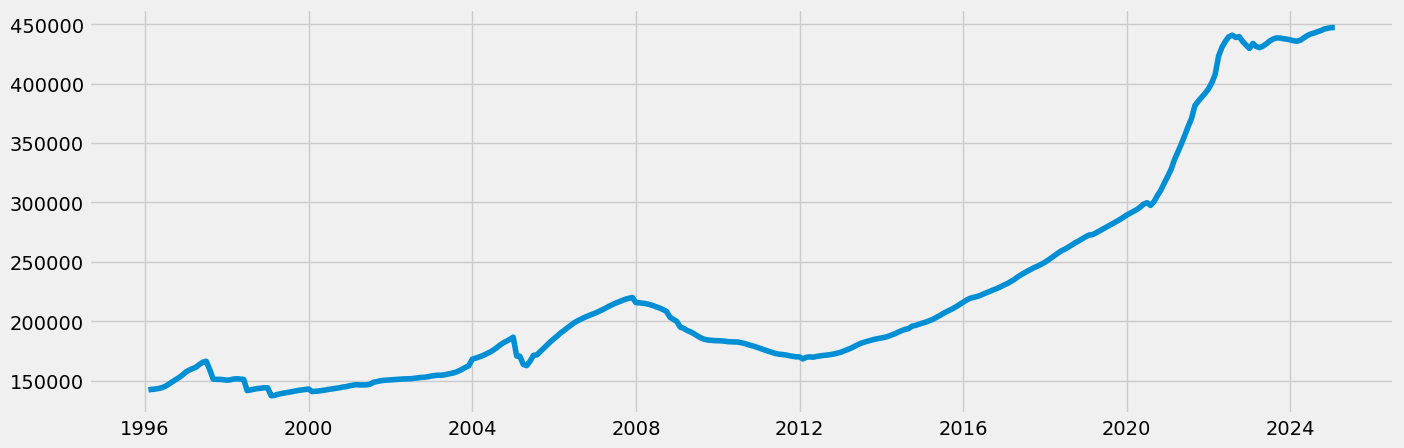

In [125]:
# Plot the data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(us_prices)

### 3. Time-series analysis: decomposition

In [128]:
# Decompose the data's components
decomposition = sm.tsa.seasonal_decompose(us_prices, model='additive')

In [130]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

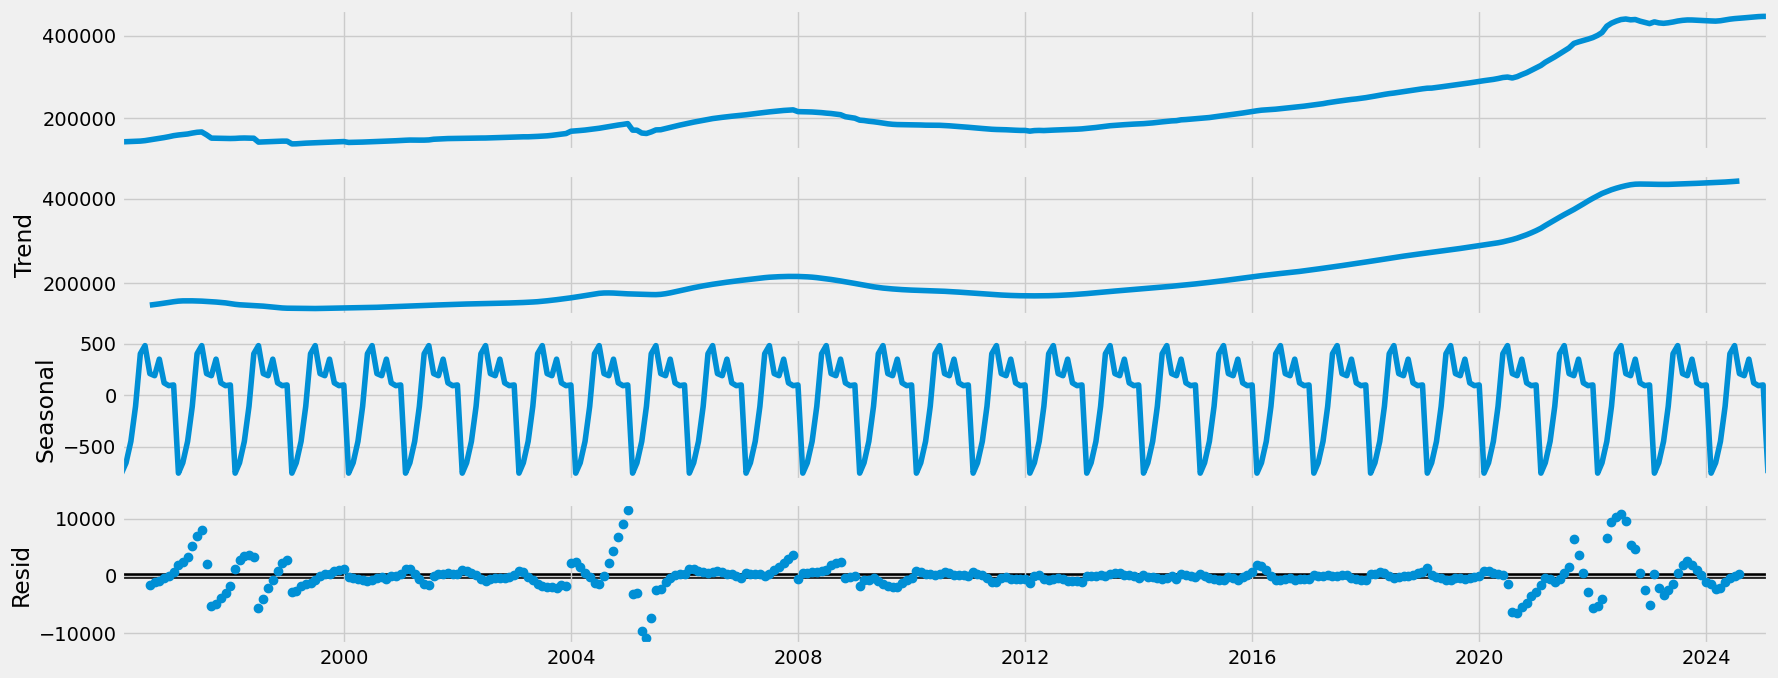

In [132]:
# Plot the separated components

decomposition.plot()
plt.show()

## Takeaways
### The trend line shows a consistent, long-term upward movement 
### The seasonal component exhibits a clear, repeating pattern each year, with predictable peaks and troughs.
### The residuals are generally centered around zero, indicating that most of the variation is captured by the trend and seasonal components.


### 4. Testing for stationarity

In [144]:
# Conduct a Dickey-Fuller test to check for stationarity

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): 
    print('Dickey-Fuller Stationarity Test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print(result)

# Apply the test on the time series
dickey_fuller(us_prices['value'])

Dickey-Fuller Stationarity Test:
Test Statistic                   0.409110
p-value                          0.981832
Number of Lags Used             10.000000
Number of Observations Used    338.000000
Critical Value (1%)             -3.449846
Critical Value (5%)             -2.870129
Critical Value (10%)            -2.571346
dtype: float64


## Hypothesis 
### Null Hypothesis (H₀): The time series has a unit root (i.e., it is non-stationary). 
### Alternative Hypothesis (H₁):** The time series is stationary. -
####  Because the test statistic (0.445619) is higher (less negative) than all critical values (e.g., -2.870155 at 5%) and the p-value (0.983123) is far above 0.05, we fail to reject the null hypothesis. This means there is insufficient evidence to conclude that the series is stationary, indicating that the data likely require further transformation (e.g., differencing or detrending) for stationarity-based modeling.

### 5. Stationarizing the Zillow Real Estate Data

In [152]:
# Stationarize the data by using the differencing technique
data_diff = us_prices - us_prices.shift(1)

# Remove any mising values as a result of the differencing
data_diff.dropna(inplace=True)

In [154]:
data_diff.head()

,value
datetime,
1996-02-29,439.666667
1996-03-31,263.833333
1996-04-30,463.000000
1996-05-31,725.166667
1996-06-30,1151.833333


In [156]:
data_diff.columns

Index(['value'], dtype='object')

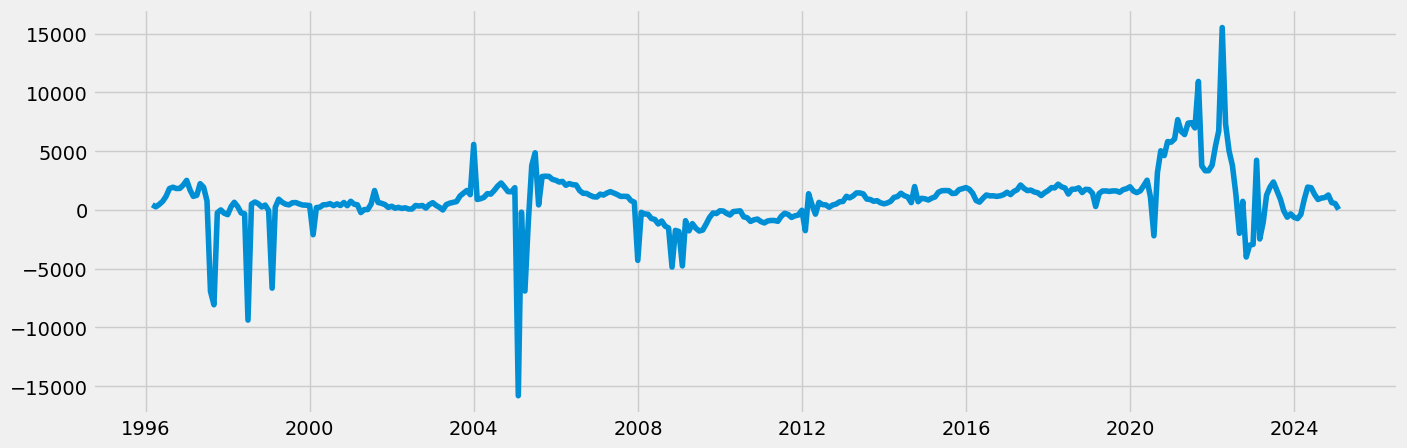

In [158]:
# Plot the time series to see what the effect of the differencing
plt.figure(figsize=(15,5), dpi = 100)
plt.plot(data_diff)

In [160]:
# Recheck for stationarity by running another Dickey_Fuller test
dickey_fuller(data_diff['value'])


Dickey-Fuller Stationarity Test:
Test Statistic                  -2.995848
p-value                          0.035284
Number of Lags Used              9.000000
Number of Observations Used    338.000000
Critical Value (1%)             -3.449846
Critical Value (5%)             -2.870129
Critical Value (10%)            -2.571346
dtype: float64


#### Since the test statistic (-2.995848) is less than the 5% critical value (-2.870129) and the p-value (0.035284) is below the conventional significance level of 0.05, we **reject the null hypothesis**. This result indicates that the time series is **stationary**.

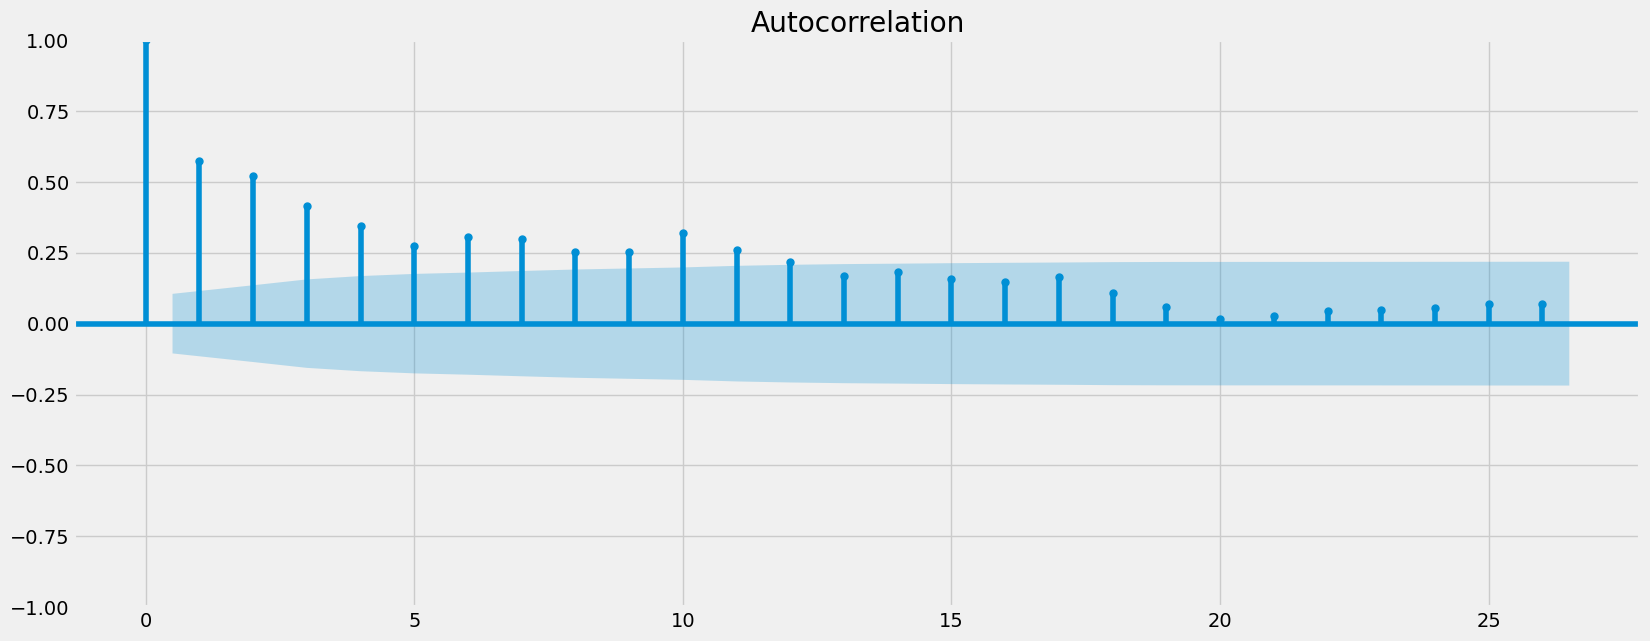

In [163]:
# Check the data's autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_diff)
plt.show()